In [1]:
!python -m venv .venv

In [2]:
!pwd

/home/chisphung/ALPR_Fisheye/notebooks


In [3]:
%cd ..

/home/chisphung/ALPR_Fisheye


In [4]:
import matplotlib.pyplot as plt
from model.yolo.ultralytics.models.yolo.model import YOLO

In [6]:
from PIL import Image
import cv2
import torch
import math 
# import function.utils_rotate as utils_rotate
from IPython.display import display
import os
# import function.helper as helper

In [110]:
img = cv2.imread('/home/chisphung/ALPR_Fisheye/dataset/test/xemay1522_jpg.rf.e0ade499f088c424976b3a53a3f70b74.jpg')

In [111]:
model = YOLO('/home/chisphung/ALPR_Fisheye/weight/recognition_v11m.pt')  # load a pretrained model (recommended for training)

In [112]:
plates = model.predict(img)  # predict on an image


0: 512x768 1 BSV, 31.7ms
Speed: 1.5ms preprocess, 31.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 768)


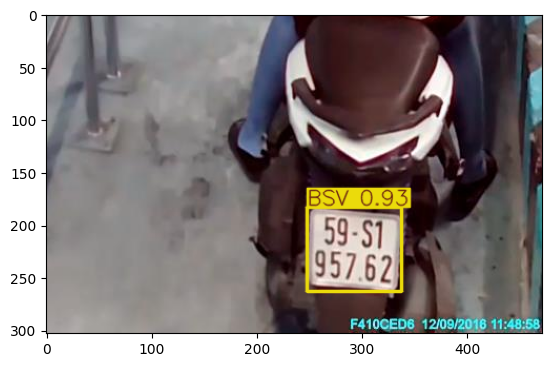

In [113]:
draw_box = plates[0].plot()
plt.imshow(draw_box)
plt.show()
# -*- coding: utf-8 -*-

In [114]:
list_plates = plates[0].boxes.xyxy.tolist()  # x1, y1, x2, y2
list_plates

[[248.16343688964844,
  183.6365966796875,
  338.65887451171875,
  263.8430480957031]]

In [115]:
for plate in list_plates:
    flag = 0
    x = int(plate[0]) # xmin
    y = int(plate[1]) # ymin
    w = int(plate[2] - plate[0]) # xmax - xmin
    h = int(plate[3] - plate[1]) # ymax - ymin  
    crop_img = img[y:y+h, x:x+w]
    cv2.rectangle(img, (int(plate[0]),int(plate[1])), (int(plate[2]),int(plate[3])), color = (0,0,225), thickness = 2)
    cv2.imwrite("crop.jpg", crop_img)
    rc_image = cv2.imread("crop.jpg")


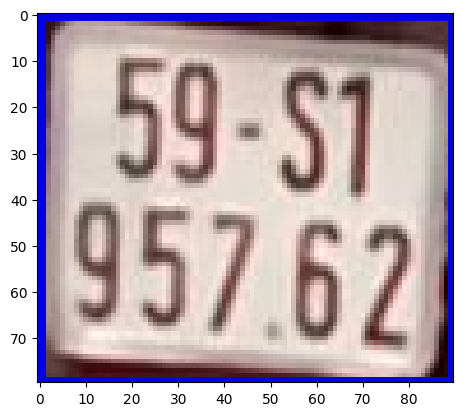

In [116]:
plt.imshow(crop_img)

In [117]:
ocr_model = YOLO('/home/chisphung/ALPR_Fisheye/weight/Charcter-LP.pt')  # load a pretrained model (recommended for training)


0: 576x640 1 1, 2 5s, 1 6, 3 7s, 2 9s, 2 Cs, 1 T, 36.9ms
Speed: 1.5ms preprocess, 36.9ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 640)


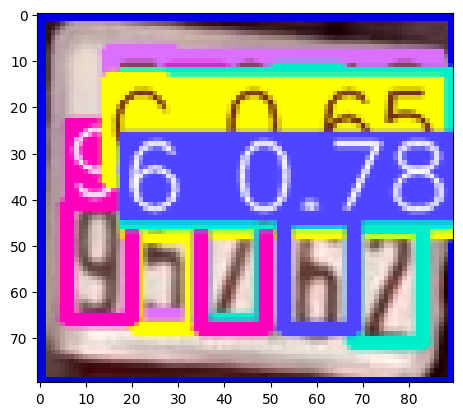

In [118]:
res = ocr_model(crop_img)  # predict on an image
plt.imshow(res[0].plot())

In [131]:
import math

# line fitting helpers
def linear_equation(x1, y1, x2, y2):
    b = y1 - (y2 - y1) * x1 / (x2 - x1)
    a = (y1 - b) / x1
    return a, b

def check_point_linear(x, y, x1, y1, x2, y2):
    a, b = linear_equation(x1, y1, x2, y2)
    y_pred = a * x + b
    return math.isclose(y_pred, y, abs_tol=3)

# main plate decoding
def decode_plate(yolo_model, im):
    results = yolo_model(im)
    r = results[0]
    boxes = r.boxes

    if boxes is None or len(boxes) == 0:
        return "unknown"

    # class-id → label map
    names = getattr(r, "names", None)
    if not names:
        names = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',
                 10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',16:'G',17:'H',18:'I',
                 19:'J',20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',
                 28:'S',29:'T',30:'U',31:'V',32:'W',33:'X',34:'Y',35:'Z'}

    # collect centers + class ids
    xyxy = boxes.xyxy.cpu().numpy()
    cls_ids = boxes.cls.cpu().numpy().astype(int)

    center_list = []
    y_sum = 0
    for bb, cid in zip(xyxy, cls_ids):
        x_c = (bb[0] + bb[2]) / 2
        y_c = (bb[1] + bb[3]) / 2
        y_sum += y_c
        center_list.append([x_c, y_c, names.get(cid, "?")])
    # print("Centers:", center_list)
    # if len(center_list) < 7 or len(center_list) > 10:
    #     return "unknown"
    
    # check if 2-line plate
    LP_type = "1"
    l_point = min(center_list, key=lambda c: c[0])
    r_point = max(center_list, key=lambda c: c[0])
    for ct in center_list:
        if l_point[0] != r_point[0]:
            if not check_point_linear(ct[0], ct[1], l_point[0], l_point[1], r_point[0], r_point[1]):
                LP_type = "2"

    y_mean = y_sum / len(center_list)

    # build plate string
    license_plate = ""
    if LP_type == "2":
        line_1 = [c for c in center_list if c[1] <= y_mean]
        line_2 = [c for c in center_list if c[1] > y_mean]

        for l1 in sorted(line_1, key=lambda x: x[0]):
            license_plate += l1[2]
        license_plate += "-"
        for l2 in sorted(line_2, key=lambda x: x[0]):
            license_plate += l2[2]
    else:
        for l in sorted(center_list, key=lambda x: x[0]):
            license_plate += l[2]

    return license_plate


In [132]:
text = decode_plate(ocr_model, crop_img)
print("Plate:", text)


0: 576x640 1 1, 2 5s, 1 6, 3 7s, 2 9s, 2 Cs, 1 T, 36.0ms
Speed: 8.9ms preprocess, 36.0ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 640)
Plate: C5971-9C57T67


In [92]:
# Get the result labels from res[0]
labels = res[0].boxes.cls if hasattr(res[0].boxes, 'cls') else None
print("Labels:", labels)
print(res[0])
print(res[0].boxes)

Labels: tensor([ 5.,  4.,  5.,  9.,  1.,  4., 29.,  1., 21.,  1.], device='cuda:0')
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}
obb: None
orig_img: array([[[  0,   0, 225],
        [  0,   0, 225],
        [  0,   0, 225],
        ...,
        [  0,   0, 225],
        [  0,   0, 225],
        [  0,   0, 225]],

       [[  0,   0, 225],
        [  0,   0, 225],
        [  0,   0, 225],
        ...,
        [  0,   0, 225],
        [  0,   0, 225],
        [  0,   0, 225]],

       [[  0,   0, 225],
        [  0,   0, 225],
        [102,  82,  87],
        ...,
        [227, 200, 20

In [93]:
import math

# license plate type classification helper function
def linear_equation(x1, y1, x2, y2):
    b = y1 - (y2 - y1) * x1 / (x2 - x1)
    a = (y1 - b) / x1
    return a, b

def check_point_linear(x, y, x1, y1, x2, y2):
    a, b = linear_equation(x1, y1, x2, y2)
    y_pred = a*x+b
    return(math.isclose(y_pred, y, abs_tol = 3))

# detect character and number in license plate
def read_plate(yolo_license_plate, im):
    LP_type = "1"
    results = yolo_license_plate(im)
    bb_list = results[0].boxes.xyxy.tolist()
    if len(bb_list) == 0 or len(bb_list) < 7 or len(bb_list) > 10:
        return "unknown"
    center_list = []
    y_mean = 0
    y_sum = 0
    for bb in bb_list:
        x_c = (bb[0]+bb[2])/2
        y_c = (bb[1]+bb[3])/2
        y_sum += y_c
        center_list.append([x_c,y_c,bb[-1]])

    # find 2 point to draw line
    l_point = center_list[0]
    r_point = center_list[0]
    for cp in center_list:
        if cp[0] < l_point[0]:
            l_point = cp
        if cp[0] > r_point[0]:
            r_point = cp
    for ct in center_list:
        if l_point[0] != r_point[0]:
            if (check_point_linear(ct[0], ct[1], l_point[0], l_point[1], r_point[0], r_point[1]) == False):
                LP_type = "2"

    y_mean = int(int(y_sum) / len(bb_list))
    # size = results.pandas().s

    # 1 line plates and 2 line plates
    line_1 = []
    line_2 = []
    license_plate = ""
    if LP_type == "2":
        for c in center_list:
            if int(c[1]) > y_mean:
                line_2.append(c)
            else:
                line_1.append(c)
        for l1 in sorted(line_1, key = lambda x: x[0]):
            license_plate += str(l1[2])
        license_plate += "-"
        for l2 in sorted(line_2, key = lambda x: x[0]):
            license_plate += str(l2[2])
    else:
        for l in sorted(center_list, key = lambda x: x[0]):
            license_plate += str(l[2])
    return license_plate

In [94]:
read_plate(ocr_model, crop_img)


0: 480x640 3 1s, 2 4s, 2 5s, 1 9, 1 L, 1 T, 28.4ms
Speed: 1.3ms preprocess, 28.4ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 640)


'15.60317993164062515.34663009643554716.06388473510742217.43898010253906216.80107879638672-29.7699985504150430.20096588134765630.68543434143066430.64979934692382831.22889518737793'

In [95]:
print(res1)

NameError: name 'res1' is not defined